# Delay Differential Equations : DDEs

This example demonstrates the use of DDE solvers to handle delayed system of equations. In this case, we model the dimensionless [delay-logistic equation](https://www.math.fsu.edu/~bertram/lectures/delay.pdf). 

$$ \frac{dy}{dt} = \alpha y \left(1 - y(t-\tau) \right) $$



This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/dde.ipynb).

In [1]:
import time

import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Using 64-bit precision is important when solving problems with tolerances of 1e-8 (or smaller).

In [2]:
jax.config.update("jax_enable_x64", True)

In order to model a delayed system we need to instantiate its vector field and its history function $\phi(t) = y(t<0)$ (i.e. initial condition).

In [3]:
def delay_logistic_vf(t, y, args, *, history):
    alpha = args
    return alpha * y * (1 - history[0])


def history_function(t):
    return 2.0

A DDE's vector field holds an additional argument `history` compared to an ODE's. The `history` variable refers to the delayed terms of your equation (here $y(t-\tau)$). 

We need to instantiate the `Delays` object that encompasses all of the information needed to integrate properly our DDE. The arguments `initial_discontinuities` also need to be given. It accounts for the discontinuities found in the history function.   


In our case we only have 0 since $y\prime(t=0^{-}) \neq y\prime(t=0^{+})$ because $y\prime(t=0^{+}) = - 2 \alpha$ and   $y\prime(t=0^{-}) = 0$.  
We choose $\tau=1$.

In [4]:
delays = diffrax.Delays(
    delays=[lambda t, y, args: 1.0], initial_discontinuities=jnp.array([0.0])
)

Since DDEs require dense solutions we need to set `diffrax.SaveAt`'s argument `dense=True` in `diffrax.diffeqsolve`. 

In [5]:
@jax.jit
def main(alpha):
    terms = diffrax.ODETerm(delay_logistic_vf)
    t0 = 0.0
    t1 = 20.0
    ts = jnp.linspace(0, 20, 200)
    solver = diffrax.Bosh3()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)
    sol = diffrax.diffeqsolve(
        terms,
        solver,
        t0,
        t1,
        ts[1] - ts[0],
        y0=history_function,
        saveat=diffrax.SaveAt(ts=ts, dense=True),
        stepsize_controller=stepsize_controller,
        delays=delays,
        args=alpha,
    )
    return sol

Do one iteration to JIT compile everything. Then time the second iteration.

Integration took in 0.0011103153228759766 seconds.


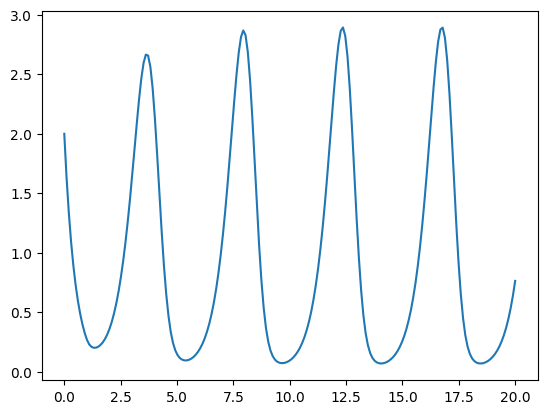

In [6]:
alpha = 2.0
main(alpha)

start = time.time()
sol = main(alpha)
end = time.time()
print(f"Integration took in {end - start} seconds.")

plt.plot(sol.ts, sol.ys)
plt.show()

We can also change the `alpha` term and see its influence on the dynamics.

Integration took in 0.0009412765502929688 seconds.


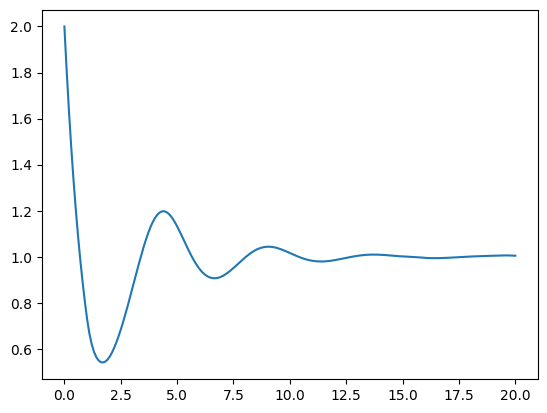

In [7]:
main(1)

start = time.time()
sol = main(1)
end = time.time()
print(f"Integration took in {end - start} seconds.")

plt.plot(sol.ts, sol.ys)
plt.show()